<a href="https://colab.research.google.com/github/DANIELVSHVL/DIPLOM/blob/main/RF_CNN_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Загрузка данных из real_filled и answers, очистка от ненужных вагонов

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
real_filled = pd.read_csv("/content/drive/MyDrive/rzd_diploma/data/real_filled.csv", index_col=0)
answers = pd.read_csv("/content/drive/MyDrive/rzd_diploma/data/answers.csv")
def filter_garbage_wagons(real_filled):
    """
    Удаляет из real_filled все вагоны купе и плацкарта, в которых:
    - все значения = 0
    - все значения = 1
    - все значения = NaN
    Возвращает очищенный DataFrame, транспонированный обратно
    """
    real_filled = real_filled.T  # строки = вагоны
    real_filled.index.name = "вагон"
    kept = []
    removed = []
    for wagon_id, row in real_filled.iterrows():
        vec = row.values
        clean_vec = [v for v in vec if v in [0, 1]]
        if len(clean_vec) == 0 or all(v == 0 for v in clean_vec) or all(v == 1 for v in clean_vec):
            removed.append(wagon_id)
        else:
            kept.append(wagon_id)
    real_filled_clean = real_filled.loc[kept]
    real_filled_clean = real_filled_clean.sort_index()
    real_filled_clean = real_filled_clean.T
    print("Очистка завершена:")
    print(f"До очистки: {real_filled.shape[0]} вагонов")
    print(f"Удалено бесполезных вагонов: {len(removed)}")
    print(f"После очистки: {real_filled_clean.shape[1]} вагонов")
    return real_filled_clean
real_filled_clean = filter_garbage_wagons(real_filled)
real_filled_clean_df = pd.DataFrame(real_filled_clean)
real_filled_clean_df.to_csv("/content/drive/MyDrive/rzd_diploma/data/real_filled_clean.csv")
answers_clean = answers[answers["вагон"].isin(real_filled_clean.columns)]
answers_clean_df = pd.DataFrame(answers_clean)
answers_clean_df.to_csv("/content/drive/MyDrive/rzd_diploma/data/answers_clean.csv", index=False)

Очистка завершена:
До очистки: 1296 вагонов
Удалено бесполезных вагонов: 17
После очистки: 1279 вагонов


### Диагностика очищенного датасета

In [ ]:
def diagnose_dataset(real_filled_clean, answers_clean):
    print("Диагностика перед аугментацией:\n")
    answers_clean = answers[answers["вагон"].isin(real_filled_clean.columns)]
    type_counts = answers_clean["тип"].value_counts()
    print("1. Сопоставление типов")
    print(type_counts.to_string())
    print()
    print("2. Диапазон номеров мест:")
    print(f"Мин: {answers_clean['место'].min()}")
    print(f"Макс: {answers_clean['место'].max()}\n")
    unmatched = set(real_filled_clean.columns) - set(answers_clean["вагон"])
    print(f"3️. Вагоны без строк в answers_clean (метаинформации): {len(unmatched)}")
    if unmatched:
        print(f"Примеры: {list(unmatched)[:5]}")
    print()
    print("4. Проверка NaN в критичных полях:")
    print(answers_clean[["вагон", "место", "реальный_статус"]].isna().sum().to_string())
    print()
    print("5. Распределение классов по матрице занятости (все места всех вагонов):")
    values = real_filled_clean.values.flatten()
    class_counts = pd.Series([v for v in values if v in [0, 1]]).value_counts()
    print(class_counts.to_string())
    print()
diagnose_dataset(real_filled_clean, answers_clean)


Диагностика перед аугментацией:

1. Сопоставление типов
тип
П    728
К    551

2. Диапазон номеров мест:
Мин: 1
Макс: 54

3️. Вагоны без строк в answers_clean (метаинформации): 0

4. Проверка NaN в критичных полях:
вагон              0
место              0
реальный_статус    0

5. Распределение классов по матрице занятости (все места всех вагонов):
0.0    31853
1.0    27295



# Аугментация.  Создаются 6 копий 1 вагона.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from collections import Counter
# Зоны для равномерного покрытия
# 6 зон по 6 мест — всего 36 мест в купе
zone_map_kupe = {
    1: [1, 2, 3, 4, 5, 6],
    2: [7, 8, 9, 10, 11, 12],
    3: [13, 14, 15, 16, 17, 18],
    4: [19, 20, 21, 22, 23, 24],
    5: [25, 26, 27, 28, 29, 30],
    6: [31, 32, 33, 34, 35, 36]
}
# 6 зон по 9 мест — всего 54 места в плацкарте
zone_map_plaz = {
    1: list(range(1, 10)),       # 1–9
    2: list(range(10, 19)),      # 10–18
    3: list(range(19, 28)),      # 19–27
    4: list(range(28, 37)),      # 28–36
    5: list(range(37, 46)),      # 37–45
    6: list(range(46, 55))       # 46–54
}
group_map_plaz = {
    1: [1, 2, 3, 4, 53, 54],
    2: [5, 6, 7, 8, 51, 52],
    3: [9, 10, 11, 12, 49, 51],
    4: [13, 14, 15, 16, 47, 48],
    5: [17, 18, 19, 20, 45, 46],
    6: [21, 22, 23, 24, 43, 44],
    7: [25, 26, 27, 28, 41, 42],
    8: [29, 30, 31, 32, 39, 40],
    9: [33, 34, 35, 36, 37, 38],
}

def calculate_occupancy_bin(wagon_vector: list, masked_index: int) -> int:
    """
    Делит загрузку на 6 равных интервалов по количеству занятых мест.
    Возвращает режим загрузки от 1 до 6.
    """
    valid_places = [x for x in wagon_vector if pd.notna(x)]
    total = len(valid_places)
    occupied = sum(valid_places)

    if total == 0:
        return -1  # защита от деления на 0

    occupancy_ratio = occupied / total

    if occupancy_ratio <= 1/6:
        return 1
    elif occupancy_ratio <= 2/6:
        return 2
    elif occupancy_ratio <= 3/6:
        return 3
    elif occupancy_ratio <= 4/6:
        return 4
    elif occupancy_ratio <= 5/6:
        return 5
    else:
        return 6

def get_group_number_plaz(place):
    for group_num, places in group_map_plaz.items():
        if place in places:
            return group_num
    return np.nan

def generate_augmented_dataset(real_filled_clean, answers_clean, output_prefix="/content/drive/MyDrive/rzd_diploma/data/"):
    real_filled_clean_augmented = {}
    masked_filled_clean_augmented = {}
    answers_clean_augmented = []
    wagon_types = {}

    real_filled_clean = real_filled_clean.sort_index(axis=1)
    answers_clean["вагон"] = answers_clean["вагон"].astype(str).str.strip()
    missing = 0

    for v_idx, wagon_id in enumerate(real_filled_clean.columns):
        vec = real_filled_clean[wagon_id].values.tolist()
        wagon_matches = answers_clean[answers_clean["вагон"] == wagon_id]
        if wagon_matches.empty:
            print(f"Вагон {wagon_id} не найден в answers_clean")
            missing += 1
            continue

        wagon_type = wagon_matches.iloc[0]["тип"]
        zone_map = zone_map_kupe if wagon_type == "К" else zone_map_plaz
        zone_size = 6 if wagon_type == "К" else 9

        for zone_num in range(1, 7):
            offset = ((v_idx + zone_num - 1) % zone_size)
            zone_places = zone_map[zone_num]
            if offset >= len(zone_places):
                continue

            masked_place = zone_places[offset]
            if masked_place > len(vec):
                continue

            masked_vector = vec.copy()
            masked_vector[masked_place - 1] = -1

            occupancy_bin = calculate_occupancy_bin(vec, masked_place - 1)
            new_wagon_id = f"{wagon_id}_z{zone_num}"

            real_filled_clean_augmented[new_wagon_id] = vec
            masked_filled_clean_augmented[new_wagon_id] = masked_vector
            wagon_types[new_wagon_id] = wagon_type

            match = wagon_matches[wagon_matches["место"] == masked_place]
            if not match.empty:
                row = match.iloc[0].copy()
                row["вагон"] = new_wagon_id
                row["режим_загрузки"] = occupancy_bin
                row["нижнее"] = 1 if masked_place % 2 == 1 else 0
                row["верхнее"] = 1 if masked_place % 2 == 0 else 0
                row["боковушка"] = 1 if wagon_type == "П" and 37 <= masked_place <= 54 else 0
                row["номер_места"] = masked_place
                row["номер_группы"] = get_group_number_plaz(masked_place) if wagon_type == "П" else np.nan
                row["номер_купе"] = (masked_place - 1) // 4 + 1 if wagon_type == "К" and masked_place <= 36 else np.nan
                answers_clean_augmented.append(row.to_dict())
            else:
                new_row = {
                    "вагон": new_wagon_id,
                    "место": masked_place,
                    "реальный_статус": int(vec[masked_place - 1]),
                    "тип": wagon_type,
                    "нижнее": 1 if masked_place % 2 == 1 else 0,
                    "верхнее": 1 if masked_place % 2 == 0 else 0,
                    "боковушка": 1 if (wagon_type == "П" and 37 <= masked_place <= 54) else 0,
                    "номер_места": masked_place,
                    "номер_группы": get_group_number_plaz(masked_place) if wagon_type == "П" else np.nan,
                    "номер_купе": (masked_place - 1) // 4 + 1 if wagon_type == "К" and masked_place <= 36 else np.nan,
                    "режим_загрузки": occupancy_bin
                }
                answers_clean_augmented.append(new_row)

    # Перемешиваем
    shuffled_keys = shuffle(list(real_filled_clean_augmented.keys()), random_state=42)
    real_filled_clean_augmented = {k: real_filled_clean_augmented[k] for k in shuffled_keys}
    masked_filled_clean_augmented = {k: masked_filled_clean_augmented[k] for k in shuffled_keys}
    answers_clean_augmented = [row for k in shuffled_keys for row in answers_clean_augmented if row["вагон"] == k]

    # Сохраняем
    pd.DataFrame(real_filled_clean_augmented).to_csv(f"{output_prefix}real_filled_augmented.csv")
    pd.DataFrame(masked_filled_clean_augmented).to_csv(f"{output_prefix}masked_filled_augmented.csv")
    pd.DataFrame(answers_clean_augmented).to_csv(f"{output_prefix}answers_augmented.csv", index=False)

    type_counts = Counter(wagon_types.values())
    print("Обучающие примеры (вагоны) перемешаны.")
    print(f"\nАугментация завершена.")
    print(f"Купе: {type_counts.get('К', 0)}")
    print(f"Плацкарт: {type_counts.get('П', 0)}")
    print(f"Всего аугментированных примеров (вагонов): {len(answers_clean_augmented)}")
    print(f"Пропущено примеров (вагонов): {missing}")

    return answers_clean_augmented

## Равномерное ли кол-во обучающих примеров для каждого места?

In [ ]:
import pandas as pd
# Загрузка данных
answers_clean_augmented = pd.read_csv("/content/drive/MyDrive/rzd_diploma/data/answers_augmented.csv")
# Разделение на купе и плацкарт
kupe = answers_clean_augmented[answers_clean_augmented["тип"] == "К"]
plaz = answers_clean_augmented[answers_clean_augmented["тип"] == "П"]
# Подсчёт количества примеров по номеру места
kupe_counts = kupe["номер_места"].value_counts().sort_index()
plaz_counts = plaz["номер_места"].value_counts().sort_index()
# Преобразуем в формат строки с горизонтальной ориентацией
kupe_row = pd.DataFrame([kupe_counts], index=["Купе"])
plaz_row = pd.DataFrame([plaz_counts], index=["Плацкарт"])
print("📦 Купе — обучающие примеры на место:")
print(kupe_row.to_string())
print("\n📦 Плацкарт — обучающие примеры на место:")
print(plaz_row.to_string())
print(f"\n Сколько обучающих примеров (вагонов) используется для каждого места в купе: {kupe_counts.sum()}")
print(f"Сколько обучающих примеров (вагонов) используется для каждого места в купе: {plaz_counts.sum()}")


📦 Купе — обучающие примеры на место:
номер_места  1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
Купе         92  87  88  91  97  96  96  92  87  88  91  95  97  96  91  87  88  91  91  97  96  92  87  87  87  91  96  96  92  87  87  88  91  97  96  92

📦 Плацкарт — обучающие примеры на место:
номер_места  1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
Плацкарт     81  83  79  87  81  78  85  81  83  79  87  81  78  85  81  83  79  87  76  78  85  81  83  79  78  76  78  85  81  83  81  78  76  78  85  81  87  79  83  81  87  79  78  81  87  76  78  81  78  76  78  85  78  76

 Сколько обучающих примеров (вагонов) используется для каждого места в купе: 3300
Сколько обучающих примеров (вагонов) используется для каждого места в 

In [ ]:
import pandas as pd

# Загружаем аугментированные данные
answers = pd.read_csv("/content/drive/MyDrive/rzd_diploma/data/answers_augmented.csv")

# Функция для подсчета количества обучающих примеров по режиму загрузки
def count_by_regime_total(df, wagon_type):
    filtered = df[df["тип"] == wagon_type]
    counts = filtered.groupby("режим_загрузки")["реальный_статус"].count()
    print(f"\nТип: {wagon_type} — общее количество примеров (0 + 1) по режиму загрузки:")
    print(counts)

# Подсчёт для купе и плацкарта
count_by_regime_total(answers, "К")
count_by_regime_total(answers, "П")



Тип: К — общее количество примеров (0 + 1) по режиму загрузки:
режим_загрузки
1    561
2    858
3    702
4    378
5    576
6    225
Name: реальный_статус, dtype: int64

Тип: П — общее количество примеров (0 + 1) по режиму загрузки:
режим_загрузки
1     582
2     900
3    1140
4     762
5     378
6     606
Name: реальный_статус, dtype: int64


# Загрузка данных из экзаменационной выборки

In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
import re

def occupancy_bin(count: int, wagon_type: str) -> int:
    """Режим загрузки по доле занятых мест — используется в аугментации и в валидации"""
    total_places = 36 if wagon_type == "К" else 54
    ratio = count / total_places

    if ratio <= 1/6:
        return 1
    elif ratio <= 2/6:
        return 2
    elif ratio <= 3/6:
        return 3
    elif ratio <= 4/6:
        return 4
    elif ratio <= 5/6:
        return 5
    else:
        return 6

def prepare_exam_dataset(val_path: Path):
    val_files = sorted(val_path.glob("*.txt"))
    rows, meta, y = [], [], []

    # Счётчики
    total_files = 0
    skipped_malformed = 0
    skipped_empty = 0
    skipped_all_zeros_or_ones = 0
    used_wagons = 0

    for file in val_files:
        total_files += 1
        m = re.match(r"(\d+)([КKП])\.txt", file.name)
        if not m:
            skipped_malformed += 1
            continue

        number = int(m[1])
        wagon_type = m[2].replace("K", "К")
        wagon_id = f"val_{number:03}_{wagon_type}"

        try:
            text = file.read_text(encoding="utf-8")
            tokens = re.findall(r"\d+", text)
            occupied = [int(x) for x in tokens]
            if not occupied:
                skipped_empty += 1
                continue
        except Exception as e:
            print(f"[!] Ошибка в {file.name}: {e}")
            skipped_malformed += 1
            continue

        count_occupied = len(occupied)
        total_places = 36 if wagon_type == "К" else 54

        # Пропускаем вагоны, где всё свободно или всё занято
        if count_occupied == 0 or count_occupied == total_places:
            skipped_all_zeros_or_ones += 1
            continue

        used_wagons += 1
        regime = occupancy_bin(count_occupied, wagon_type)

        for i in range(1, 55):
            if wagon_type == "К" and i > 36:
                continue

            y_true = 1 if i in occupied else 0
            vector = [
                1 if j in occupied else -1 if j == i else 0
                if wagon_type == "П" or j <= 36 else np.nan
                for j in range(1, 55)
            ]

            is_lower = 1 if i % 2 == 1 else 0
            is_upper = 1 if i % 2 == 0 else 0
            is_bokovushka = 1 if wagon_type == "П" and i >= 37 else 0
            group_number = (i - 1) // 6 + 1 if wagon_type == "П" else 0
            coupe_number = (i - 1) // 4 + 1 if wagon_type == "К" else 0

            vector += [is_lower, is_upper, is_bokovushka, i, group_number, coupe_number, regime]

            rows.append(vector)
            meta.append({
                "вагон": wagon_id,
                "тип": wagon_type,
                "номер_места": i,
                "режим_загрузки": regime
            })
            y.append(y_true)

    # Отладка
    print(f"\n Всего файлов: {total_files}")
    print(f" Использовано вагонов: {used_wagons}")
    print(f" Пропущено пустых: {skipped_empty}")
    print(f" Пропущено мусорных (всё 0 или всё 1): {skipped_all_zeros_or_ones}")
    print(f" Пропущено битых/не читаемых: {skipped_malformed}")

    place_columns = [f"место_{i}" for i in range(1, 55)]
    extra_columns = ["нижнее", "верхнее", "боковушка", "номер_места", "номер_группы", "номер_купе", "режим_загрузки"]
    all_columns = place_columns + extra_columns

    X_val_df = pd.DataFrame(rows, columns=all_columns)
    y_val_series = pd.Series(y)
    meta_val_df = pd.DataFrame(meta)
    meta_val_df["реальный_статус"] = y_val_series

    return X_val_df, y_val_series, meta_val_df
val_path = Path("/content/drive/MyDrive/rzd_diploma/data/validation_data")
X_val_df, y_val_series, meta_val_df = prepare_exam_dataset(val_path)



 Всего файлов: 165
 Использовано вагонов: 161
 Пропущено пустых: 1
 Пропущено мусорных (всё 0 или всё 1): 3
 Пропущено битых/не читаемых: 0


### Диагностика контрольного датасета

In [ ]:
# Сводка по числу вагонов в каждом режиме загрузки
def diagnose_exam_meta(meta_val_df):
    if meta_val_df.empty:
        print("⚠️ Внимание: meta_val_df пуст, нечего диагностировать.")
        return

    # Берем по 1 строке на вагон (режим загрузки одинаков для всех мест одного вагона)
    unique_wagons = meta_val_df.drop_duplicates(subset="вагон")[["вагон", "тип", "режим_загрузки"]]

    # Группируем и строим сводную таблицу по типу вагона и режиму загрузки
    summary = unique_wagons.groupby(["тип", "режим_загрузки"]).size().reset_index(name="кол-во_вагонов")
    pivot = summary.pivot(index="режим_загрузки", columns="тип", values="кол-во_вагонов").fillna(0).astype(int)
    pivot = pivot.sort_index()

    print("📊 Количество вагонов по типу и режиму загрузки (по доле занятых мест):")
    print(pivot)
diagnose_exam_meta(meta_val_df)


📊 Количество вагонов по типу и режиму загрузки (по доле занятых мест):
тип              К   П
режим_загрузки        
1               15  16
2               13  16
3               13  11
4               13  14
5               13  13
6               12  12


In [ ]:
from collections import defaultdict

# Группируем по уникальным вагонам
unique_wagons = meta_val_df.drop_duplicates(subset="вагон")[["вагон", "тип", "режим_загрузки"]]

# Считаем число занятых мест по каждому вагону
occupied_counts = defaultdict(int)
for row in meta_val_df.itertuples():
    if row.реальный_статус == 1:
        occupied_counts[row.вагон] += 1

# Добавим это в таблицу
unique_wagons["занято_мест"] = unique_wagons["вагон"].map(occupied_counts)

# Смотрим первые 10
print(unique_wagons.head(10))


         вагон тип  режим_загрузки  занято_мест
0    val_100_К   К               6           33
36   val_100_П   П               2           10
90   val_101_К   К               6           33
126  val_101_П   П               2           10
180  val_102_П   П               2           10
234  val_103_П   П               2           10
288  val_010_К   К               2           10
324  val_010_П   П               5           37
378  val_011_К   К               3           14
414  val_011_П   П               3           21


# Random Forest

## Обучение и проверка на контрольной выборке

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# === Константы: наименования признаков ===
place_columns = [f"место_{i}" for i in range(1, 55)]  # Все 54 возможных места
extra_columns = [
    "нижнее", "верхнее", "боковушка", "номер_места",
    "номер_группы", "номер_купе", "режим_загрузки"
]  # Дополнительные признаки
feature_names = place_columns + extra_columns

# === Вспомогательные функции ===
def build_features(row, vector):
    """Добавляем к вектору статуса мест дополнительные признаки.
    Обрабатываем пропущенные значения с явной проверкой pd.isna.
    """
    return vector + [
        int(row["нижнее"]),
        int(row["верхнее"]),
        int(row["боковушка"]),
        int(row["номер_места"]),
        int(0 if pd.isna(row.get("номер_группы")) else row["номер_группы"]),
        int(0 if pd.isna(row.get("номер_купе")) else row["номер_купе"]),
        int(row["режим_загрузки"])
    ]

def calculate_occupancy_bin(vec, masked_index):
    """Оценка общего уровня загрузки вагона по шкале от 1 до 6."""
    vec_copy = vec.copy()
    vec_copy[masked_index] = -1  # маскируем текущее место
    valid = [v for i, v in enumerate(vec_copy) if v in [0, 1]]
    ratio = sum(valid) / len(valid) if valid else 0
    return min(int(ratio * 6) + 1, 6)

def parse_validation_vector(column, i, wagon_type):
    """Генерация признаков для одного примера на экзамене."""
    vec = column.copy()
    vec[i] = -1
    vector = vec.fillna(-2).to_numpy().tolist()
    is_lower = 1 if i % 2 == 1 else 0
    is_bokovushka = 1 if wagon_type == "П" and i >= 37 else 0
    group_number = (i - 1) // 6 + 1 if wagon_type == "П" else 0
    coupe_number = (i - 1) // 4 + 1 if wagon_type == "К" else 0
    occupancy_bin = calculate_occupancy_bin(column.tolist(), i - 1)
    return vector + [is_lower, is_bokovushka, i, group_number, coupe_number, occupancy_bin]

# === Загрузка обучающих данных ===
masked = pd.read_csv("/content/drive/MyDrive/rzd_diploma/data/masked_filled_augmented.csv", index_col=0)
answers = pd.read_csv("/content/drive/MyDrive/rzd_diploma/data/answers_augmented.csv")

# === Формируем полный тренировочный датасет ===
X_all, y_all, meta_all = [], [], []
for _, row in answers.iterrows():
    wagon = row["вагон"]
    if wagon not in masked.columns:
        continue
    vec = masked[wagon].fillna(-2).tolist()
    X_all.append(build_features(row, vec))
    y_all.append(int(row["реальный_статус"]))
    meta_all.append({
        "вагон": wagon,
        "место": int(row["место"]),
        "тип": row["тип"],
        "реальный_статус": int(row["реальный_статус"])
    })

X_df = pd.DataFrame(X_all, columns=feature_names)
y_df = pd.Series(y_all)
meta_df = pd.DataFrame(meta_all)

# === Обучение отдельных моделей Random Forest по типу вагона ===
models = {}
for wagon_type in ["К", "П"]:
    X_type = X_df[meta_df["тип"] == wagon_type]
    y_type = y_df[meta_df["тип"] == wagon_type]
    clf = RandomForestClassifier(
        n_estimators=100,
        max_depth=8,
        class_weight={0: 1.5, 1: 1} if wagon_type == "К" else "balanced",
        random_state=42
    )
    clf.fit(X_type, y_type)
    models[wagon_type] = clf

# === Загрузка и обработка экзаменационной выборки (УЖЕ ЗАГРУЖЕНА) ===
# Здесь X_val_df, y_val_series, meta_val_df — заранее получены через prepare_exam_dataset()

# === Прогон моделей по экзаменационной выборке ===
for wagon_type in ["К", "П"]:
    mask = meta_val_df["тип"] == wagon_type
    print(f"\n=== {wagon_type} (RF, экзамен) ===")
    print(classification_report(y_val_series[mask], models[wagon_type].predict(X_val_df[mask])))



=== К (RF, экзамен) ===
              precision    recall  f1-score   support

           0       0.73      0.75      0.74      1423
           1       0.74      0.72      0.73      1421

    accuracy                           0.74      2844
   macro avg       0.74      0.74      0.74      2844
weighted avg       0.74      0.74      0.74      2844


=== П (RF, экзамен) ===
              precision    recall  f1-score   support

           0       0.80      0.75      0.77      2340
           1       0.73      0.78      0.76      2088

    accuracy                           0.76      4428
   macro avg       0.76      0.77      0.76      4428
weighted avg       0.77      0.76      0.76      4428



### F1 score по режиму загрузки для RF


=== Ошибки по классам (по режимам загрузки, экзамен RF) ===
   тип  режим_загрузки  precision    recall  f1-score  support
0    К               1   0.592900  0.770000  0.669944    300.0
1    К               2   0.707224  0.798485  0.722377    660.0
2    К               3   0.576660  0.593750  0.554107    480.0
3    К               4   0.605016  0.599206  0.573896    504.0
4    К               5   0.625857  0.791111  0.698848    450.0
5    К               6   0.770494  0.877778  0.820644    450.0
6    П               1   0.749210  0.865569  0.803197    729.0
7    П               2   0.706846  0.749730  0.720542    927.0
8    П               3   0.594338  0.581081  0.585772    666.0
9    П               4   0.778568  0.780488  0.778355    738.0
10   П               5   0.749735  0.749648  0.657362    711.0
11   П               6   0.736932  0.858447  0.793062    657.0


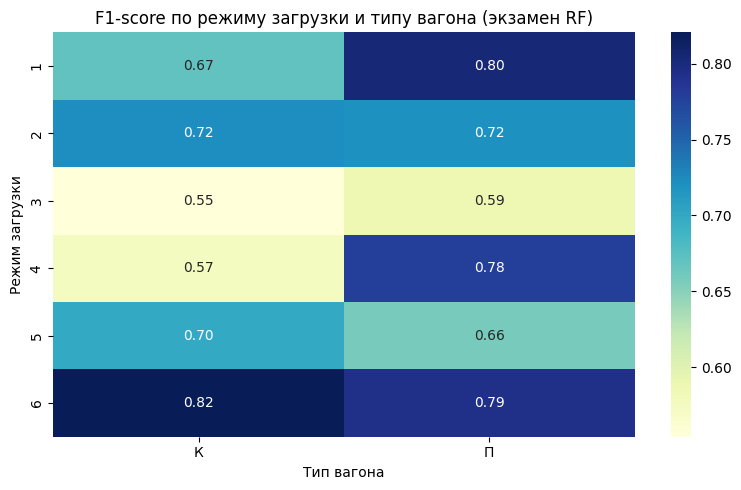

In [ ]:
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# === Эффективное добавление режима загрузки ===
meta_val_df["режим_загрузки"] = [
    calculate_occupancy_bin(X_val_df.loc[i, place_columns].tolist(), row["номер_места"] - 1)
    for i, row in meta_val_df.iterrows()
]

# === Предсказания моделей по типу (векторно, без apply) ===
meta_val_df["предсказание"] = -1
for wagon_type in ["К", "П"]:
    mask = meta_val_df["тип"] == wagon_type
    meta_val_df.loc[mask, "предсказание"] = models[wagon_type].predict(X_val_df.loc[mask])

# === Группировка по типу и режиму загрузки ===
grouped = meta_val_df.groupby(["тип", "режим_загрузки"])
group_reports = {
    (vtype, load_bin): classification_report(
        group["реальный_статус"], group["предсказание"], output_dict=True, zero_division=0
    )["weighted avg"]
    for (vtype, load_bin), group in grouped
}

# === Преобразование в таблицу
report_df = pd.DataFrame.from_dict(group_reports, orient="index")
report_df.index.names = ["тип", "режим_загрузки"]
report_df.reset_index(inplace=True)

# === Табличный вывод
print("\n=== Ошибки по классам (по режимам загрузки, экзамен RF) ===")
print(report_df[["тип", "режим_загрузки", "precision", "recall", "f1-score", "support"]])

# === Визуализация f1-score
pivot = report_df.pivot(index="режим_загрузки", columns="тип", values="f1-score")
plt.figure(figsize=(8, 5))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("F1-score по режиму загрузки и типу вагона (экзамен RF)")
plt.ylabel("Режим загрузки")
plt.xlabel("Тип вагона")
plt.tight_layout()
plt.show()


### Важность признаков

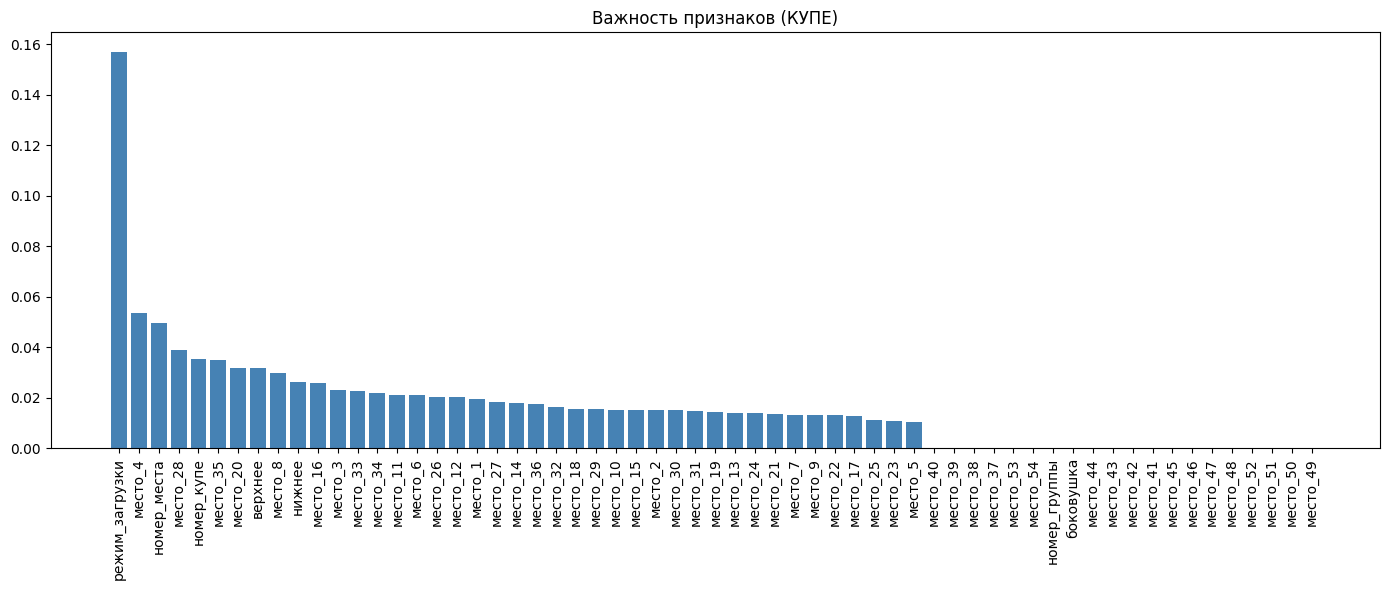

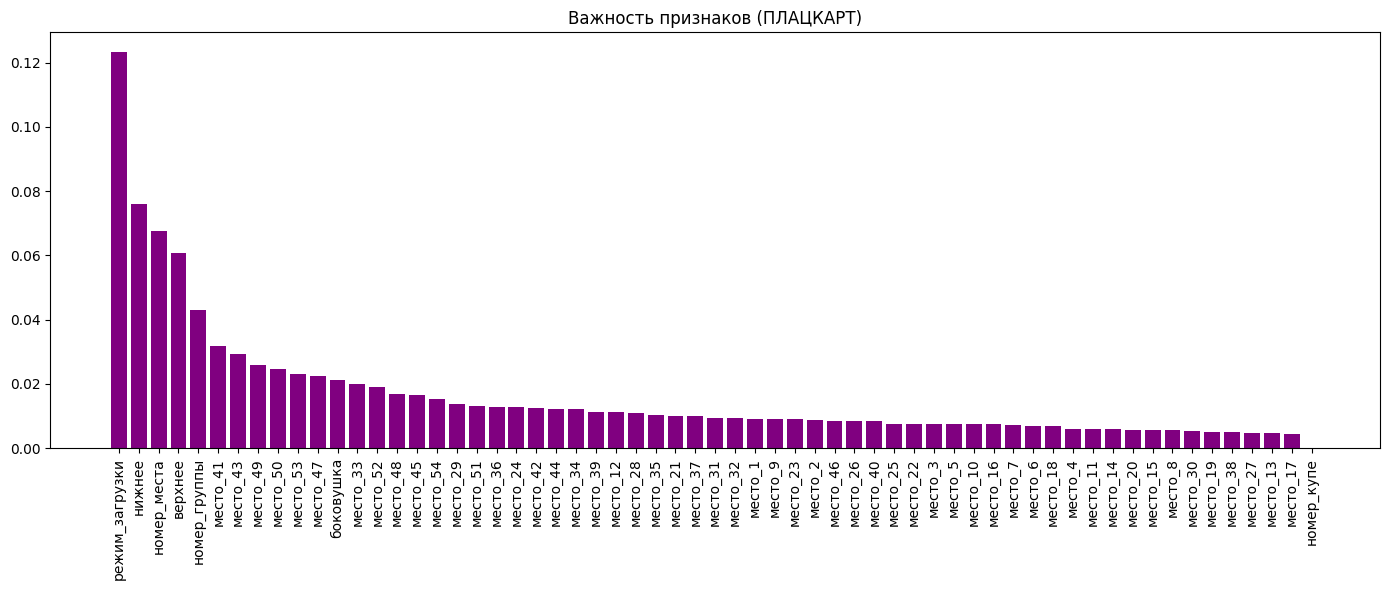

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Извлекаем важности признаков из обученных моделей
importances = {
    "КУПЕ": models["К"].feature_importances_,
    "ПЛАЦКАРТ": models["П"].feature_importances_
}
# Общий список названий признаков (места + дополнительные поля)
feature_names = [f"место_{i}" for i in range(1, 55)] + [
    "нижнее", "верхнее", "боковушка", "номер_места", "номер_группы", "номер_купе", "режим_загрузки"
]

# Визуализация для каждой модели
for title, values in importances.items():
    indices = np.argsort(values)[::-1]
    plt.figure(figsize=(14, 6))
    plt.bar(range(len(values)), values[indices], color="purple" if title == "ПЛАЦКАРТ" else "steelblue")
    plt.xticks(range(len(values)), [feature_names[i] for i in indices], rotation=90)
    plt.title(f"Важность признаков ({title})")
    plt.tight_layout()
    plt.show()


### Сохранение модели RF

In [ ]:
import joblib
# Сохранение обученных моделей в папку /models
joblib.dump(models["К"], "/content/drive/MyDrive/rzd_diploma/models/rf_model_kupe.joblib")
joblib.dump(models["П"], "/content/drive/MyDrive/rzd_diploma/models/rf_model_plaz.joblib")


['/content/drive/MyDrive/rzd_diploma/models/rf_model_plaz.joblib']

# CNN

## Подготовка данных для CNN (только для купе)

In [ ]:
import pandas as pd
import numpy as np

# Загрузка файлов с маскированными векторами и метками
masked_df = pd.read_csv("/content/drive/MyDrive/rzd_diploma/data/masked_filled_augmented.csv", index_col=0)
answers_df = pd.read_csv("/content/drive/MyDrive/rzd_diploma/data/answers_augmented.csv")

X_kupe_cnn, y_kupe_cnn = [], []

# Проход по строкам с купейными вагонами
for _, row in answers_df.iterrows():
    if row["тип"] != "К":
        continue

    wagon = row["вагон"]
    if wagon not in masked_df.columns:
        continue

    vec = masked_df[wagon].fillna(-2).tolist()
    vec = [(v if v in [0, 1, -1] else -2) for v in vec][:36]

    if len(vec) == 36:
        # Формируем 2×18 матрицу, где строка 0 — верхние места, строка 1 — нижние
        upper = vec[1::2]  # чётные места: 2, 4, ..., 36
        lower = vec[0::2]  # нечётные места: 1, 3, ..., 35
        matrix = np.array([upper, lower])  # shape = (2, 18)
        X_kupe_cnn.append(matrix)
        y_kupe_cnn.append(int(row["реальный_статус"]))

# Приведение к формату Tensorflow (samples, height, width, channels)
X_kupe_cnn = np.array(X_kupe_cnn).reshape(-1, 2, 18, 1)
y_kupe_cnn = np.array(y_kupe_cnn)


## Разделение на тестовую и обучающую выборку и создание моделей

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

# Стратифицированное разбиение (сохраняет пропорции классов)
sss_kupe = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_idx, test_idx in sss_kupe.split(X_kupe_cnn, y_kupe_cnn):
    Xk_train, Xk_test = X_kupe_cnn[train_idx], X_kupe_cnn[test_idx]
    yk_train, yk_test = y_kupe_cnn[train_idx], y_kupe_cnn[test_idx]


## Архитектура и обучение CNN

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, GlobalMaxPooling2D, Dense, Dropout
from keras.callbacks import EarlyStopping

# CNN модель под формат входа 2×18×1 (2 строки: верхние и нижние места, 18 колонок: купе)
model_cnn_kupe = Sequential([
    Conv2D(32, kernel_size=(2, 2), padding='same', activation='relu', input_shape=(2, 18, 1)),
    BatchNormalization(),
    Conv2D(64, kernel_size=(2, 2), padding='same', activation='relu'),
    BatchNormalization(),
    GlobalMaxPooling2D(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Бинарная классификация
])


model_cnn_kupe.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Раннее прекращение по валидационному loss
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Обучение модели
history_kupe = model_cnn_kupe.fit(
    Xk_train, yk_train,
    validation_data=(Xk_test, yk_test),
    epochs=30,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.6290 - loss: 1.1815 - val_accuracy: 0.5424 - val_loss: 0.6797
Epoch 2/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8150 - loss: 0.4312 - val_accuracy: 0.4879 - val_loss: 0.6760
Epoch 3/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8167 - loss: 0.4074 - val_accuracy: 0.6121 - val_loss: 0.6640
Epoch 4/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8361 - loss: 0.3760 - val_accuracy: 0.7758 - val_loss: 0.6331
Epoch 5/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8258 - loss: 0.3841 - val_accuracy: 0.8333 - val_loss: 0.6014
Epoch 6/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8285 - loss: 0.3860 - val_accuracy: 0.8394 - val_loss: 0.5619
Epoch 7/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8312 - loss: 0.3881 - val_accuracy: 0.8303 - val_loss: 0.5180
Epoch 8/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8394 - loss: 0.3694 - val_accuracy: 0.8394 - val_loss: 0.

## Экзамен CNN

In [ ]:
from sklearn.metrics import classification_report

# Выборка вагонов купе из validation_data
meta_exam_kupe = meta_val_df[meta_val_df["тип"] == "К"].reset_index(drop=True)
y_exam_kupe = y_val_series[meta_exam_kupe.index].to_numpy()

# Выделяем только 36 мест, затем разбиваем на верх/низ
X_exam_kupe_flat = X_val_df.loc[meta_exam_kupe.index, place_columns[:36]].to_numpy()
upper = X_exam_kupe_flat[:, 1::2]  # Верхние (чётные места)
lower = X_exam_kupe_flat[:, 0::2]  # Нижние (нечётные места)
X_exam_kupe = np.stack([upper, lower], axis=1).reshape(-1, 2, 18, 1)

# Предсказания модели
y_pred_exam_kupe = (model_cnn_kupe.predict(X_exam_kupe) > 0.5).astype(int)

# Отчёт по качеству модели
print("\n=== КУПЕ (CNN, 2×18, ЭКЗАМЕН) ===")
print(classification_report(y_exam_kupe, y_pred_exam_kupe))


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

=== КУПЕ (CNN, 2×18, ЭКЗАМЕН) ===
              precision    recall  f1-score   support

           0       0.81      0.72      0.76      1443
           1       0.74      0.82      0.78      1401

    accuracy                           0.77      2844
   macro avg       0.78      0.77      0.77      2844
weighted avg       0.78      0.77      0.77      2844



## **F1 score по режиму загрузки для CNN**


=== CNN (купе): ошибки по режимам загрузки ===
   режим_загрузки  precision    recall  f1-score  support
0               1   0.581549  0.662100  0.555504    438.0
1               2   0.398697  0.395131  0.370775    534.0
2               3   0.449226  0.437276  0.438144    558.0
3               4   0.568803  0.572727  0.566290    330.0
4               5   0.531917  0.425094  0.331881    534.0
5               6   0.641279  0.626667  0.506061    450.0


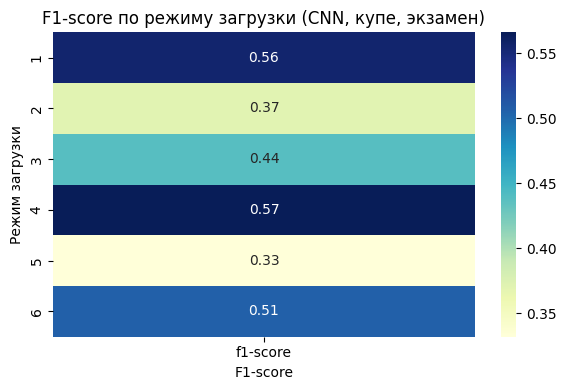

In [ ]:
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# === Восстановим векторы заселения по вагону
def build_wagon_vectors(meta_df, y_true):
    wagon_vectors = {}
    for i, row in meta_df.iterrows():
        wagon = row["вагон"]
        seat = row["номер_места"]
        status = int(y_true[i])
        if wagon not in wagon_vectors:
            wagon_vectors[wagon] = [np.nan] * 54
        wagon_vectors[wagon][seat - 1] = status
    return wagon_vectors

# === Получаем заселённость для вычисления режима загрузки
vectors_cnn = build_wagon_vectors(meta_exam_kupe, y_exam_kupe)

# === Добавляем предсказание и загрузку
meta_exam_kupe["предсказание"] = y_pred_exam_kupe.flatten()

def get_bin(row):
    vec = vectors_cnn[row["вагон"]]
    return calculate_occupancy_bin(vec, row["номер_места"] - 1)

meta_exam_kupe["режим_загрузки"] = meta_exam_kupe.apply(get_bin, axis=1)

# === Группировка по режиму загрузки
grouped = meta_exam_kupe.groupby("режим_загрузки")
group_reports = {}

for load_bin, group in grouped:
    y_true = group["реальный_статус"]
    y_pred = group["предсказание"]
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    group_reports[load_bin] = report["weighted avg"]

# === Таблица
report_df_cnn = pd.DataFrame.from_dict(group_reports, orient="index")
report_df_cnn.index.name = "режим_загрузки"
report_df_cnn.reset_index(inplace=True)

# === Вывод
print("\n=== CNN (купе): ошибки по режимам загрузки ===")
print(report_df_cnn[["режим_загрузки", "precision", "recall", "f1-score", "support"]])

# === Тепловая карта
pivot = report_df_cnn.set_index("режим_загрузки")[["f1-score"]]
plt.figure(figsize=(6, 4))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="YlGnBu", cbar=True)
plt.title("F1-score по режиму загрузки (CNN, купе, экзамен)")
plt.ylabel("Режим загрузки")
plt.xlabel("F1-score")
plt.tight_layout()
plt.show()


## Сохранение модели CNN

In [ ]:
model_cnn_kupe.save("/content/drive/MyDrive/rzd_diploma/models/cnn_model_kupe.h5")


# Реализация перцептрона

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

# === Загрузка и транспонирование входных данных ===
masked_filled_mlp = pd.read_csv('/content/drive/MyDrive/rzd_diploma/data/masked_filled_augmented.csv', index_col=0).T
answers_mlp = pd.read_csv('/content/drive/MyDrive/rzd_diploma/data/answers_augmented.csv')

# === Устранение NaN в метаполях (важно!)
answers_mlp = answers_mlp.fillna({
    "номер_группы": 0,
    "номер_купе": 0
})

# === Добавление и нормализация метапризнаков ===
def normalize_meta(meta_block):
    meta = meta_block.copy()
    meta[:, 3] = (meta[:, 3] - 1) / 53  # номер_места: 1–54
    meta[:, 4] = (meta[:, 4] - 0) / 8   # номер_группы: 0–8
    meta[:, 5] = (meta[:, 5] - 0) / 8   # номер_купе: 0–8
    meta[:, 6] = (meta[:, 6] - 1) / 5   # режим_загрузки: 1–6
    return meta

meta_features = answers_mlp[[
    "нижнее", "верхнее", "боковушка",
    "номер_места", "номер_группы", "номер_купе", "режим_загрузки"
]].astype(float).values
meta_features = normalize_meta(meta_features)

# === Общие метки и индексы ===
types_mlp = answers_mlp["тип"].values
y_all_mlp = answers_mlp["реальный_статус"].astype(int).values
masked_places_mlp = answers_mlp["место"].values
wagon_ids_mlp = masked_filled_mlp.index.values

# === КУПЕ: 36 мест + 7 мета
kupe_mask = types_mlp == "К"
X_kupe_places = masked_filled_mlp[kupe_mask].iloc[:, :36].to_numpy()
X_kupe_meta = meta_features[kupe_mask]
X_kupe_mlp = np.hstack([X_kupe_places, X_kupe_meta])
y_kupe_mlp = y_all_mlp[kupe_mask]
masked_places_kupe = masked_places_mlp[kupe_mask]
wagon_ids_kupe = wagon_ids_mlp[kupe_mask]
answers_mlp_kupe = answers_mlp[kupe_mask].reset_index(drop=True)

# === ПЛАЦКАРТ: 54 места + 7 мета
plaz_mask = types_mlp == "П"
X_plaz_places = masked_filled_mlp[plaz_mask].iloc[:, :54].to_numpy()
X_plaz_meta = meta_features[plaz_mask]
X_plaz_mlp = np.hstack([X_plaz_places, X_plaz_meta])
y_plaz_mlp = y_all_mlp[plaz_mask]
masked_places_plaz = masked_places_mlp[plaz_mask]
wagon_ids_plaz = wagon_ids_mlp[plaz_mask]
answers_mlp_plaz = answers_mlp[plaz_mask].reset_index(drop=True)

# === Контроль: никаких NaN
assert np.isnan(X_kupe_mlp).sum() == 0, "❌ В kupе всё ещё есть NaN"
assert np.isnan(X_plaz_mlp).sum() == 0, "❌ В плацкарте всё ещё есть NaN"


## Обучение

In [ ]:
from sklearn.model_selection import train_test_split

def train_mlp_model(X_mlp, y_mlp, wagon_type_label, answers_df_mlp, test_size=0.1):
    # === Разделение на обучение и тест с гарантированной стратификацией ===
    idx = np.arange(len(y_mlp))
    X_train_mlp, X_test_mlp, y_train_mlp, y_test_mlp, train_idx, test_idx = train_test_split(
        X_mlp, y_mlp, idx, test_size=test_size, random_state=42, stratify=y_mlp
    )

    # === Meta для теста — берём по индексам test_idx
    meta_val_df_mlp = answers_df_mlp.iloc[test_idx].reset_index(drop=True)

    # === Нормализация мест через StandardScaler
    num_place_features = 54 if wagon_type_label == 'П' else 36
    scaler = StandardScaler()
    X_train_places = scaler.fit_transform(X_train_mlp[:, :num_place_features])
    X_test_places = scaler.transform(X_test_mlp[:, :num_place_features])

    # === Нормализация мета вручную
    X_train_meta = normalize_meta(X_train_mlp[:, -7:])
    X_test_meta = normalize_meta(X_test_mlp[:, -7:])

    # === Объединение
    X_train_mlp = np.hstack([X_train_places, X_train_meta])
    X_test_mlp = np.hstack([X_test_places, X_test_meta])

    # === Архитектура модели
    model_mlp = Sequential([
        Dense(128, activation='relu', input_shape=(X_train_mlp.shape[1],)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

    model_mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # === Early stopping
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=4, restore_best_weights=True
    )

    model_mlp.fit(
        X_train_mlp, y_train_mlp,
        validation_data=(X_test_mlp, y_test_mlp),
        epochs=50,
        batch_size=64,
        class_weight=None,
        callbacks=[early_stop],
        verbose=1
    )

    # === Отчёт
    y_pred_mlp = (model_mlp.predict(X_test_mlp) > 0.5).astype(int)
    print(f'\nОтчёт по типу вагона {wagon_type_label}:')
    print(confusion_matrix(y_test_mlp, y_pred_mlp))
    print(classification_report(y_test_mlp, y_pred_mlp))

    return model_mlp, meta_val_df_mlp, y_test_mlp, y_pred_mlp


In [ ]:
# === Обучение и оценка: ПЛАЦКАРТ ===
clf_mlp_plaz, meta_val_df_plaz_mlp, y_exam_plaz_mlp, y_pred_exam_plaz_mlp = train_mlp_model(
    X_plaz_mlp, y_plaz_mlp, 'П', answers_mlp_plaz
)
print("\nBalanced Accuracy (Плацкарт, MLP):", balanced_accuracy_score(y_exam_plaz_mlp, y_pred_exam_plaz_mlp))

# === Обучение и оценка: КУПЕ ===
clf_mlp_kupe, meta_val_df_kupe_mlp, y_exam_kupe_mlp, y_pred_exam_kupe_mlp = train_mlp_model(
    X_kupe_mlp, y_kupe_mlp, 'К', answers_mlp_kupe
)
print("\nBalanced Accuracy (Купе, MLP):", balanced_accuracy_score(y_exam_kupe_mlp, y_pred_exam_kupe_mlp))


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6306 - loss: 0.7291 - val_accuracy: 0.7460 - val_loss: 0.5263
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7152 - loss: 0.5827 - val_accuracy: 0.7506 - val_loss: 0.4922
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7533 - loss: 0.5110 - val_accuracy: 0.7757 - val_loss: 0.4685
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7737 - loss: 0.5015 - val_accuracy: 0.7826 - val_loss: 0.4618
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7713 - loss: 0.4776 - val_accuracy: 0.8032 - val_loss: 0.4513
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7975 - loss: 0.4462 - val_accuracy: 0.7918 - val_loss: 0.4517
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8030 - loss: 0.4423 - val_accuracy: 0.8101 - val_loss: 0.4429
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7982 - loss: 0.4444 - val_accuracy: 0.8032 - val_loss: 0.4410
Epo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.6271 - loss: 0.8221 - val_accuracy: 0.7545 - val_loss: 0.5439
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7101 - loss: 0.6021 - val_accuracy: 0.7515 - val_loss: 0.5168
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7214 - loss: 0.5822 - val_accuracy: 0.7606 - val_loss: 0.5078
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7604 - loss: 0.5226 - val_accuracy: 0.7424 - val_loss: 0.5144
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7523 - loss: 0.5276 - val_accuracy: 0.7424 - val_loss: 0.5021
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7586 - loss: 0.5233 - val_accuracy: 0.7485 - val_loss: 0.4852
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7711 - loss: 0.4932 - val_accuracy: 0.7576 - val_loss: 0.4900
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7811 - loss: 0.4558 - val_accuracy: 0.7636 - val_loss: 0.4860
Ep

In [ ]:
# === Деление на купе и плацкарт
kupe_mask = meta_val_df["тип"] == "К"
plaz_mask = meta_val_df["тип"] == "П"

# === КУПЕ: 36 признаков мест + нормализованные 7 мета
X_val_kupe_places = X_val_df[kupe_mask].iloc[:, :36].to_numpy()
X_val_kupe_meta = normalize_meta(X_val_df[kupe_mask].iloc[:, -7:].to_numpy())
X_val_kupe_mlp = np.hstack([X_val_kupe_places, X_val_kupe_meta])
y_val_kupe_mlp = y_val_series[kupe_mask].to_numpy()
meta_val_df_kupe_mlp_exam = meta_val_df[kupe_mask].reset_index(drop=True)

# === ПЛАЦКАРТ: 54 признака мест + нормализованные 7 мета
X_val_plaz_places = X_val_df[plaz_mask].iloc[:, :54].to_numpy()
X_val_plaz_meta = normalize_meta(X_val_df[plaz_mask].iloc[:, -7:].to_numpy())
X_val_plaz_mlp = np.hstack([X_val_plaz_places, X_val_plaz_meta])
y_val_plaz_mlp = y_val_series[plaz_mask].to_numpy()
meta_val_df_plaz_mlp_exam = meta_val_df[plaz_mask].reset_index(drop=True)

# === Предсказания и отчёты
print("\n=== КУПЕ (MLP, exam) ===")
y_pred_exam_kupe_mlp = (clf_mlp_kupe.predict(X_val_kupe_mlp) > 0.5).astype(int)
# y_pred_custom = (clf_mlp_kupe.predict(X_val_kupe_mlp) > 0.3).astype(int)

print(classification_report(y_val_kupe_mlp, y_pred_exam_kupe_mlp))

print("\n=== ПЛАЦКАРТ (MLP, exam) ===")
y_pred_exam_plaz_mlp = (clf_mlp_plaz.predict(X_val_plaz_mlp) > 0.5).astype(int)
print(classification_report(y_val_plaz_mlp, y_pred_exam_plaz_mlp))



=== КУПЕ (MLP, exam) ===
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       0.80      0.38      0.52      1423
           1       0.59      0.90      0.72      1421

    accuracy                           0.64      2844
   macro avg       0.70      0.64      0.62      2844
weighted avg       0.70      0.64      0.62      2844


=== ПЛАЦКАРТ (MLP, exam) ===
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
              precision    recall  f1-score   support

           0       0.84      0.48      0.61      2340
           1       0.60      0.89      0.72      2088

    accuracy                           0.67      4428
   macro avg       0.72      0.69      0.67      4428
weighted avg       0.73      0.67      0.66      4428



## F1 score по режиму загрузки для MLP


=== MLP: ошибки по типам и режимам загрузки (экзамен) ===
   тип  режим_загрузки  precision    recall  f1-score  support
0    К               1   0.693758  0.600000  0.629779    300.0
1    К               2   0.759044  0.557576  0.601902    660.0
2    К               3   0.617692  0.527083  0.496618    480.0
3    К               4   0.635378  0.575397  0.484353    504.0
4    К               5   0.691268  0.762222  0.711967    450.0
5    К               6   0.896156  0.882222  0.831168    450.0
6    П               1   0.799291  0.662551  0.712044    729.0
7    П               2   0.717256  0.617044  0.648275    927.0
8    П               3   0.553345  0.450450  0.419113    666.0
9    П               4   0.762965  0.728997  0.698375    738.0
10   П               5   0.721475  0.746835  0.655735    711.0
11   П               6   0.736932  0.858447  0.793062    657.0


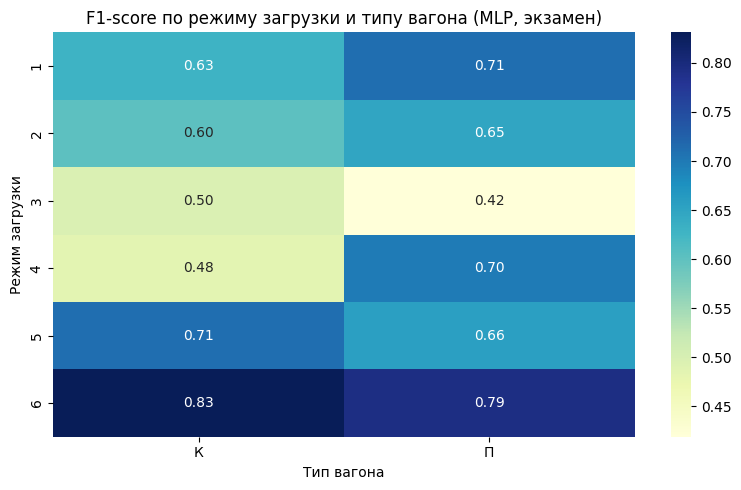

In [ ]:
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# === Собираем заселение по вагонам из meta_val_df
def build_wagon_vectors(meta_df, y_true):
    wagon_vectors = {}

    for i, row in meta_df.iterrows():
        wagon = row["вагон"]
        seat = row["номер_места"]
        status = int(y_true[i])  # ← исправлено здесь

        if wagon not in wagon_vectors:
            wagon_vectors[wagon] = [np.nan] * 54

        wagon_vectors[wagon][seat - 1] = status

    return wagon_vectors


# === Формируем exam_df
def build_exam_df(meta_df, y_true, y_pred, wagon_vectors):
    df = meta_df.copy()
    df["реальный_статус"] = y_true
    df["предсказание"] = y_pred

    def get_bin(row):
        vec = wagon_vectors[row["вагон"]]
        return calculate_occupancy_bin(vec, row["номер_места"] - 1)

    df["режим_загрузки"] = df.apply(get_bin, axis=1)
    return df

# Получаем вектора заселения
vectors_kupe = build_wagon_vectors(meta_val_df_kupe_mlp_exam, y_val_kupe_mlp)
vectors_plaz = build_wagon_vectors(meta_val_df_plaz_mlp_exam, y_val_plaz_mlp)

# Собираем exam_df
exam_df_kupe = build_exam_df(meta_val_df_kupe_mlp_exam, y_val_kupe_mlp, y_pred_exam_kupe_mlp, vectors_kupe)
exam_df_plaz = build_exam_df(meta_val_df_plaz_mlp_exam, y_val_plaz_mlp, y_pred_exam_plaz_mlp, vectors_plaz)
exam_df = pd.concat([exam_df_kupe, exam_df_plaz], ignore_index=True)

# === Группировка по типу и загрузке
group_reports = {}
for (vtype, load_bin), group in exam_df.groupby(["тип", "режим_загрузки"]):
    report = classification_report(
        group["реальный_статус"], group["предсказание"],
        output_dict=True, zero_division=0
    )
    group_reports[(vtype, load_bin)] = report["weighted avg"]

# === Сводим в таблицу
report_df = pd.DataFrame.from_dict(group_reports, orient="index")
report_df.index.names = ["тип", "режим_загрузки"]
report_df.reset_index(inplace=True)

print("\n=== MLP: ошибки по типам и режимам загрузки (экзамен) ===")
print(report_df[["тип", "режим_загрузки", "precision", "recall", "f1-score", "support"]])

# === Тепловая карта f1-score
pivot = report_df.pivot(index="режим_загрузки", columns="тип", values="f1-score")
plt.figure(figsize=(8, 5))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("F1-score по режиму загрузки и типу вагона (MLP, экзамен)")
plt.ylabel("Режим загрузки")
plt.xlabel("Тип вагона")
plt.tight_layout()
plt.show()


## Важность признаков


🔍 Расчёт важности признаков для: КУПЕ


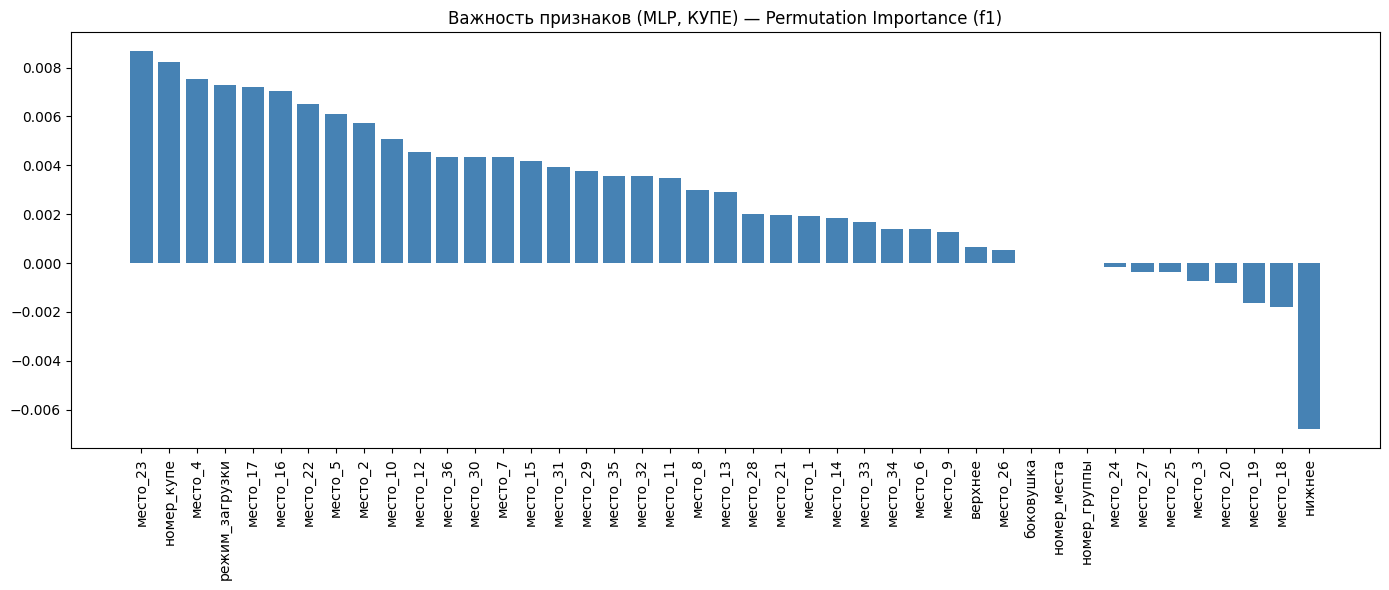


🔍 Расчёт важности признаков для: ПЛАЦКАРТ


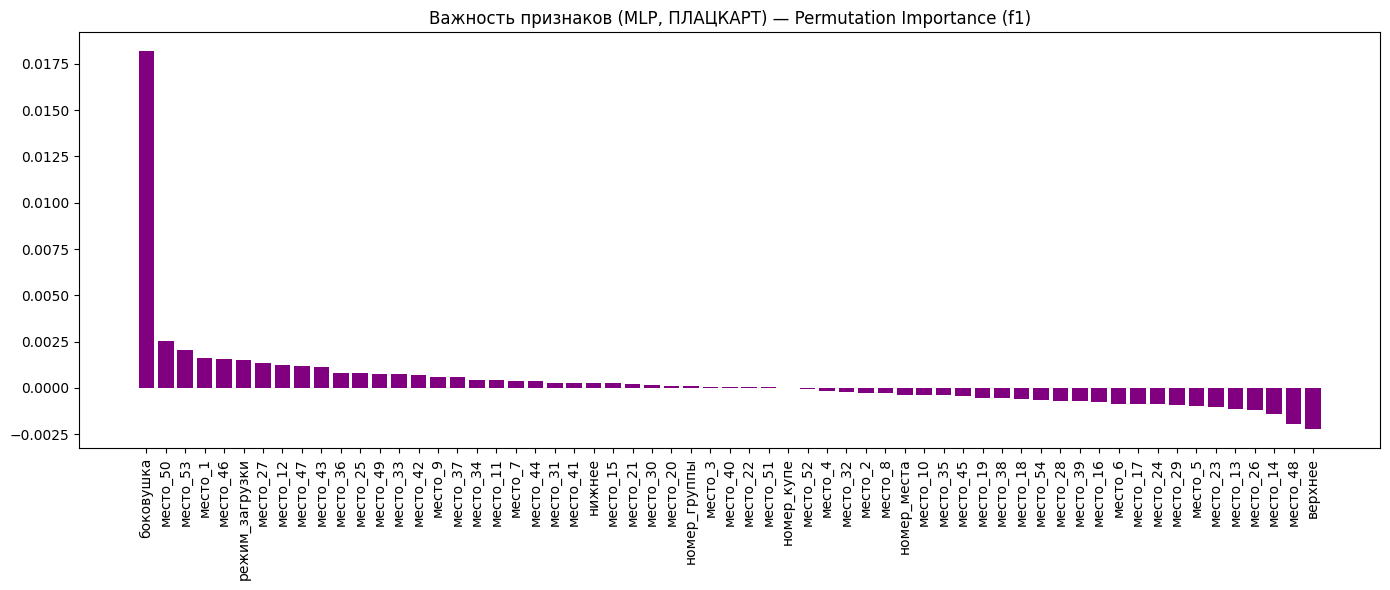

In [ ]:
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator
import matplotlib.pyplot as plt
import numpy as np
class KerasWrapper(BaseEstimator):
    def __init__(self, model):
        self.model = model

    def predict(self, X):
        return (self.model.predict(X, verbose=0) > 0.5).astype(int)

    def fit(self, X, y=None):
        # Заглушка: sklearn требует наличие метода fit
        return self

    def get_params(self, deep=True):
        return {}

    def set_params(self, **params):
        return self


# === Подготовка: модели, данные, названия признаков
mlp_models = {
    "КУПЕ": (clf_mlp_kupe, X_val_kupe_mlp, y_val_kupe_mlp, 36),
    "ПЛАЦКАРТ": (clf_mlp_plaz, X_val_plaz_mlp, y_val_plaz_mlp, 54)
}

feature_names_by_type = {
    "КУПЕ": [f"место_{i}" for i in range(1, 37)] + [
        "нижнее", "верхнее", "боковушка", "номер_места", "номер_группы", "номер_купе", "режим_загрузки"
    ],
    "ПЛАЦКАРТ": [f"место_{i}" for i in range(1, 55)] + [
        "нижнее", "верхнее", "боковушка", "номер_места", "номер_группы", "номер_купе", "режим_загрузки"
    ]
}

# === Перебор по типам вагонов
for label, (model, X_val, y_val, num_places) in mlp_models.items():
    print(f"\n🔍 Расчёт важности признаков для: {label}")

    wrapped_model = KerasWrapper(model)

    result = permutation_importance(
        wrapped_model, X_val, y_val,
        scoring="f1", n_repeats=5, random_state=42, n_jobs=-1
    )

    sorted_idx = result.importances_mean.argsort()[::-1]
    names = [feature_names_by_type[label][i] for i in sorted_idx]
    values = result.importances_mean[sorted_idx]

    # === Визуализация
    plt.figure(figsize=(14, 6))
    plt.bar(range(len(values)), values, color="steelblue" if label == "КУПЕ" else "purple")
    plt.xticks(range(len(values)), names, rotation=90)
    plt.title(f"Важность признаков (MLP, {label}) — Permutation Importance (f1)")
    plt.tight_layout()
    plt.show()


### Сохранение модели MLP

In [ ]:
import tensorflow as tf

# Сохранение обученных моделей в папку /models
clf_mlp_kupe.save("/content/drive/MyDrive/rzd_diploma/models/mlp_model_kupe_with_meta.h5")
clf_mlp_plaz.save("/content/drive/MyDrive/rzd_diploma/models/mlp_model_plaz_with_meta.h5")